In [25]:
import matplotlib.pyplot as plt
import statsmodels.api as sm 
import scipy.stats as stats
import seaborn as sns
import pandas as pd 
import numpy as np
import scipy
import random
import itertools


from statsmodels.formula.api import ols
from sklearn.metrics import mean_squared_error
from neuroCombat import neuroCombat
from statistics import mean, stdev
from patsy import dmatrix, cr
from math import sqrt
from sklearn.model_selection import train_test_split

sns.set_theme(context="talk")
pal = sns.color_palette()

### functions

In [100]:
def remove_outlier(df, index):
    Q1 = df[index].quantile(0.25)
    Q3 = df[index].quantile(0.75)

    IQR = Q3 - Q1

    filter = (df[index] >= Q1 - 2*IQR) &  (df[index] <= Q3 + 2*IQR)
    outlier =  (df[index] <= Q1 - 2*IQR) |  (df[index] >= Q3 + 2*IQR)

    return df.loc[filter], df.loc[outlier]

def clean_dataframe(df, index):
  df = df[(df != 0).all(1)]
  df = df.dropna()
  
  df_inliers, df_outlier = remove_outlier(df, index)

  return df_inliers, df_outlier

def cohens_d(c0, c1):
  std_diff = sqrt((stdev(c0) ** 2 + stdev(c1) ** 2) / 2)
  return (mean(c0) - mean(c1)) / std_diff


def hue_regplot(data, x, y, hue, palette=None, legend=False, **kwargs):
    
  regplots = []
  levels = data[hue].unique()
  pal = sns.color_palette("husl", n_colors=len(levels))

  i = 0
  if legend:
    for key in levels:
      regplots.append(sns.regplot(x=x, y=y, data=data[data[hue] == key], color=pal[i], label= key))
      # plt.legend(bbox_to_anchor=(1.02, 0.5), loc="center left")
      i +=1
  else:
    for key in levels:
      regplots.append(sns.regplot(x=x, y=y, data=data[data[hue] == key], color=pal[i]))
      i +=1

  return regplots
  
def bootstrap(df, model, n_boot, n_sample_age):

    df_age = df.loc[ (df['Age'] >= 74) & (df['Age'] <= 80) ]
    list_knots = np.unique(df_age['Age'])


    x = np.zeros((n_boot,))
    bs_replicates = np.zeros((n_boot,n_sample_age))
    x = np.zeros((n_boot,n_sample_age))
    for i in range(n_boot):
        k = random.choice(list_knots)
        bs_sample = np.random.choice(df['Age'], size=n_sample_age) ## create bootstrap
        bs_sample = sorted(bs_sample)
        x[i,:] = bs_sample
        fit = model.predict(dmatrix("bs(Age, knots=(k,), degree=3)",{"Age": bs_sample, "k":k},return_type = 'dataframe' ))
    
        bs_replicates[i,:] = fit
    return bs_replicates, x

In [41]:
def model_1(df, x, y, covariates, knots, threshold=0.005):
  k = [1,2,3]
  ### cubic model -full model -- def models(x,y, knots)
  # formula = "bs(Age, knots = 77, degree=3) + Cov"
  # cubic_x1 = dmatrix(formula, {"Age": df[x], 'Cov':df[covariates]}, return_type = 'dataframe')

  cubic_x1=dmatrix("bs(Age, knots=(77,), degree=3)",{"Age": df[x]},return_type = 'dataframe' )
  cubic_model = sm.GLM(df[y], cubic_x1).fit()
  
  ### linear regression to compare -- reduced model
  covariates.insert(0,x)
  reg_x1 = df[covariates]
  reg_x1 = sm.add_constant(reg_x1)
  regression_model = sm.OLS(df[y], reg_x1).fit()
  
  ### polyniomal regression order 3 to compare -- reduced model
  # age_x = df[ ['Age']]
  # age_x.insert(1, "Age2",  np.power(age_x['Age'], 2))
  # age_x.insert(2, "Age3",  np.power(age_x['Age'], 3))
  # age_x = sm.add_constant(age_x)
  # polynomial_model = sm.OLS(df[y], age_x).fit()




  ### likelihood ratio test --- calculate likelihood ratio Chi-Squared test statistic ## difference of log-likelihood
  LR_statistic = -2*(regression_model.llf-cubic_model.llf)

  #calculate p-value of test statistic using 2 degrees of freedom
  p_val = stats.chi2.sf(LR_statistic, 2)
  char = '<' if p_val < 0.005 else '>'
  test_result = "likelihood ratio test: ({:.4f}) {} {}".format(p_val, char, 0.005)



  return cubic_model, regression_model, test_result


def plot_two_models(df, x, y, covariates, m_cub, m_reg, knots, t):
  tmp = df.sort_values('Age')
  df_lim = tmp
  
  sns.scatterplot(x=x, y=y, data=df_lim, alpha=0.4)

  formula = "bs(Age, knots = 77, degree=3) + Cov"


  fit_cubic = m_cub.predict(dmatrix("bs(Age, knots=(77,), degree=3)",{"Age": df_lim[x]},return_type = 'dataframe' ))

  ### likelihood ratio test --- calculate likelihood ratio Chi-Squared test statistic ## difference of log-likelihood
  LR_statistic = -2*(m_reg.llf-m_cub.llf)

  #calculate p-value of test statistic using 2 degrees of freedom
  p_val = stats.chi2.sf(LR_statistic, 2)
  char = '<' if p_val < 0.005 else '>'
  test_result = "{} - likelihood ratio test: ({:.4f}) {} {}".format(t, p_val, char, 0.005)

  res = pd.DataFrame({'x':df_lim[x], 'y':fit_cubic})

  sns.lineplot(x='x', y='y', data=res, label=test_result, ci=80)

  plt.xlabel(x)
  plt.ylabel(y)
  plt.legend()

In [110]:
def model_2(df, x, y, covariates, knots, threshold=0.005):

  data_dict = {"Age": df[x], "indicator": df['Tissu'], 'Cov':df[covariates]}

  ### cubic model -full model -- def models(x,y, knots)
  cubic_x1=dmatrix("bs(Age, knots=(77,), degree=3)",{"Age": df[x]},return_type = 'dataframe' )


  x1 = dmatrix("1 +indicator*bs(Age, knots = (77,), degree=3) + Cov", data_dict, return_type = 'dataframe')
  m1 = sm.GLM(df[y], x1).fit()

  ### cubic model without interaction -- reduced model
  x2 = dmatrix("indicator + bs(Age, knots = (77,), degree=3) + Cov", data_dict, return_type = 'dataframe')
  m2 = sm.GLM(df[y], x2).fit()

  return m1, m2



def plot_interaction_models(df, x, y, covariates, m1, m2, knots):
  tmp = df.sort_values('Age')
  df_lim = tmp
  data_dict = {"Age": df_lim[x], "indicator": df_lim['Tissu'], 'Cov':df_lim[covariates]}


  sns.scatterplot(x=x, y=y, data=df_lim, hue='indicator', alpha=0.4)
  
  ## interaction model
  fit1 = m1.predict(dmatrix("indicator*bs(Age, knots =({}, {}, {}, {}), degree=3) + Cov".format(knots[0],knots[1],knots[2],knots[3]), data_dict, return_type = 'dataframe'))
  
  ## no interaction model
  fit2 = m2.predict(dmatrix("indicator + bs(Age, knots = ({}, {}, {}, {}), degree=3) + Cov".format(knots[0],knots[1],knots[2],knots[3]), data_dict, return_type = 'dataframe'))

  ### likelihood ratio test -- calculate likelihood ratio Chi-Squared test statistic ## difference of log-likelihood
  LR_statistic = -2*(m1.llf-m2.llf)

  ## calculate p-value of test statistic using 2 degrees of freedom
  p_val = stats.chi2.sf(LR_statistic, 2)
  char = '<' if p_val < 0.005 else '>'
  test_result = "likelihood ratio test: ({:.4f}) {} {}".format( p_val, char, 0.005)

  plt.plot(df_lim[x], fit1, linewidth = 2.5, label=test_result)
  # plt.plot(df_lim[x], fit2, linewidth = 2.5, label='model without interaction')


  plt.xlabel(x)
  plt.ylabel(y)
  plt.legend()

In [127]:
filedir = '/home/local/VANDERBILT/dolel/Documents/rsHRF_project/output/WM_GM_analysis/csv_harmonized/Model_and_TR/'
params = ['Height', 'DipHeight', 'TroughHeight', 'PeakIntegral', 'DipIntegral','TroughIntegral', 'Time2peak', 'Time2dip', 'Time2trough',  'FWHM']
# params = ['Height', 'PeakIntegral', 'Time2peak']

In [ ]:
### plot comBAT performance for english presentation

pal = sns.color_palette() ## 0,1 -- 3,4 -- light-dark
fg = plt.figure(figsize=(40,30))
j = 0
# params = ['Height', 'PeakIntegral', 'Time2peak']
for i in range(3):
    feature = params[i]
    file = filedir + feature + '_canonical.csv'
    df = pd.read_csv(file)

    df_models_count = pd.DataFrame(df['Scanner'].value_counts())
    scans_to_keep = df_models_count.loc[ df_models_count['Scanner'] >= 26].index.to_numpy()

    df_TR_count = pd.DataFrame(df['TR'].value_counts())
    TR_to_keep = df_TR_count.loc[ df_TR_count['TR'] >= 50].index.to_numpy()
    TR_to_keep = TR_to_keep.T

    df = df.loc[ df['TR'].isin([0.607, 3.0])]
    df = df.loc[ df['Scanner'].isin(scans_to_keep)]
    
    df = df.sort_values('TR')
    df, _ = remove_outlier(df, 'WM_Harmonization_TR_and_Scanner')


    # df_2 = df.loc[ df['TR'] == 3]
    # df_2.insert(5, "Mean_Brain",df_2[["GM", "WM"]].mean(axis=1), True)
    # df_2, _ = clean_dataframe(df_2, 'Mean_Brain')


    # df_1 = df.loc[ df['TR'] == 0.607]
    # df_1.insert(5, "Mean_Brain",df_1[["GM", "WM"]].mean(axis=1), True)
    # # df_1["Mean_Brain"] = 
    # df_1, _ = clean_dataframe(df_1, 'Mean_Brain')
    # df = pd.concat([df_2, df_1])


    plt.subplot(3,4,j+1)
    # df, _ = remove_outlier(df, 'WM_Harmonization_TR_and_Scanner')
    # df = df.loc[(df['Age'] >=65)
    hue_regplot(df, 'Age', 'WM', 'TR', legend=True)
    plt.title('Changes in {} before ComBAT - TR color'.format(feature))
    plt.legend()

    plt.subplot(3,4,j+2)
    hue_regplot(df, 'Age', 'WM_Harmonization_TR_and_Scanner', 'TR', legend=True)
    plt.title('Changes in {} after ComBAT - TR color'.format(feature))
    plt.legend()

    plt.subplot(3,4,j+3)
    hue_regplot(df, 'Age', 'WM', 'Scanner', legend=True)
    plt.title('Changes in {} before ComBAT - Scanner color'.format(feature))

    plt.subplot(3,4,j+4)
    hue_regplot(df, 'Age', 'WM_Harmonization_TR_and_Scanner', 'Scanner', legend=True)
    plt.title('Changes in {} after ComBAT - Scanner color'.format(feature))
    plt.legend(bbox_to_anchor=(1.02, 0.5), loc="center left")


    plt.suptitle('Repetition Time and Scanner effect on data before and after harmonization')

    j +=4
# fg.savefig('presentation_plot_TR_scanners_effects.png')

### 1. cohen's d - effect size across features

In [9]:
# from asyncio.subprocess import SubprocessStreamProtocol
manufacturer = ['GE', 'Philips', 'Siemens']
labels_age = ['[65;70]',']70;75]',']75;80]', ']80;85]', ']85;90]']

combination = list(itertools.combinations(labels_age, 2))
combination = list(itertools.combinations(manufacturer, 2))


nb_manu = len(combination)
nb_features = len(params) 
mat_d = np.zeros(shape=(nb_manu,nb_features))

tissus = ['WM', 'WM_Harmonization_TR_and_Scanner']
name =  ['WM before harmonization', 'WM after harmonization of TR and scanners']
min_x, max_x = 0, 0


df = pd.read_csv(filedir + 'Height.csv')
# df = df.drop_duplicates(subset='Subject')
df = df.dropna(subset='Sex')


# df = df.loc[(df['Age'] >=65) & (df['Age'] <=90)]
# df['Age'] = pd.cut(df.Age,bins=[65, 70, 75, 80, 85, 90],labels=labels_age)


In [109]:
# print(dff.to_string())

In [133]:
def set_axis(fig, ax, params, y_axis_name, test, name):
    nb_features = len(params)
    nb_manu = len(y_axis_name)

    fig.subplots_adjust(hspace=1)

    ax.set_xticks(np.arange(nb_features)+0.5, params, rotation=45, fontsize=20)
    ax.set_yticks(np.arange(nb_manu)+0.5, y_axis_name, rotation=0, fontsize=20)

    ax.set_title("{} score for each feature in {:}".format(test,name), fontsize=25,pad=30)
    ax.set_xlabel("HRF feature",labelpad=30, fontsize=20)
    ax.set_ylabel("scanner effect studied",labelpad=30, fontsize=20)

    return fig

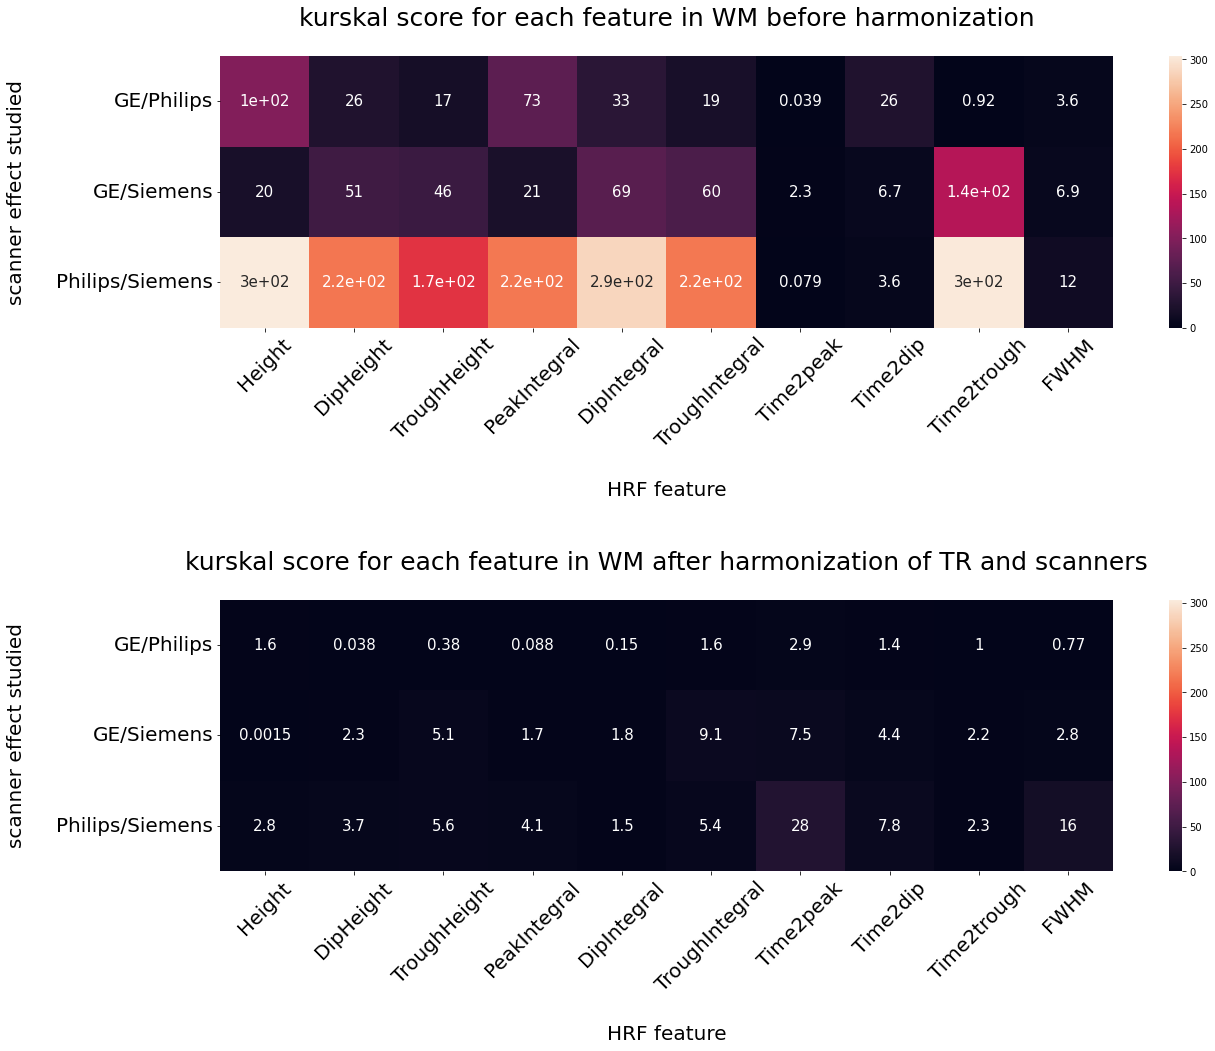

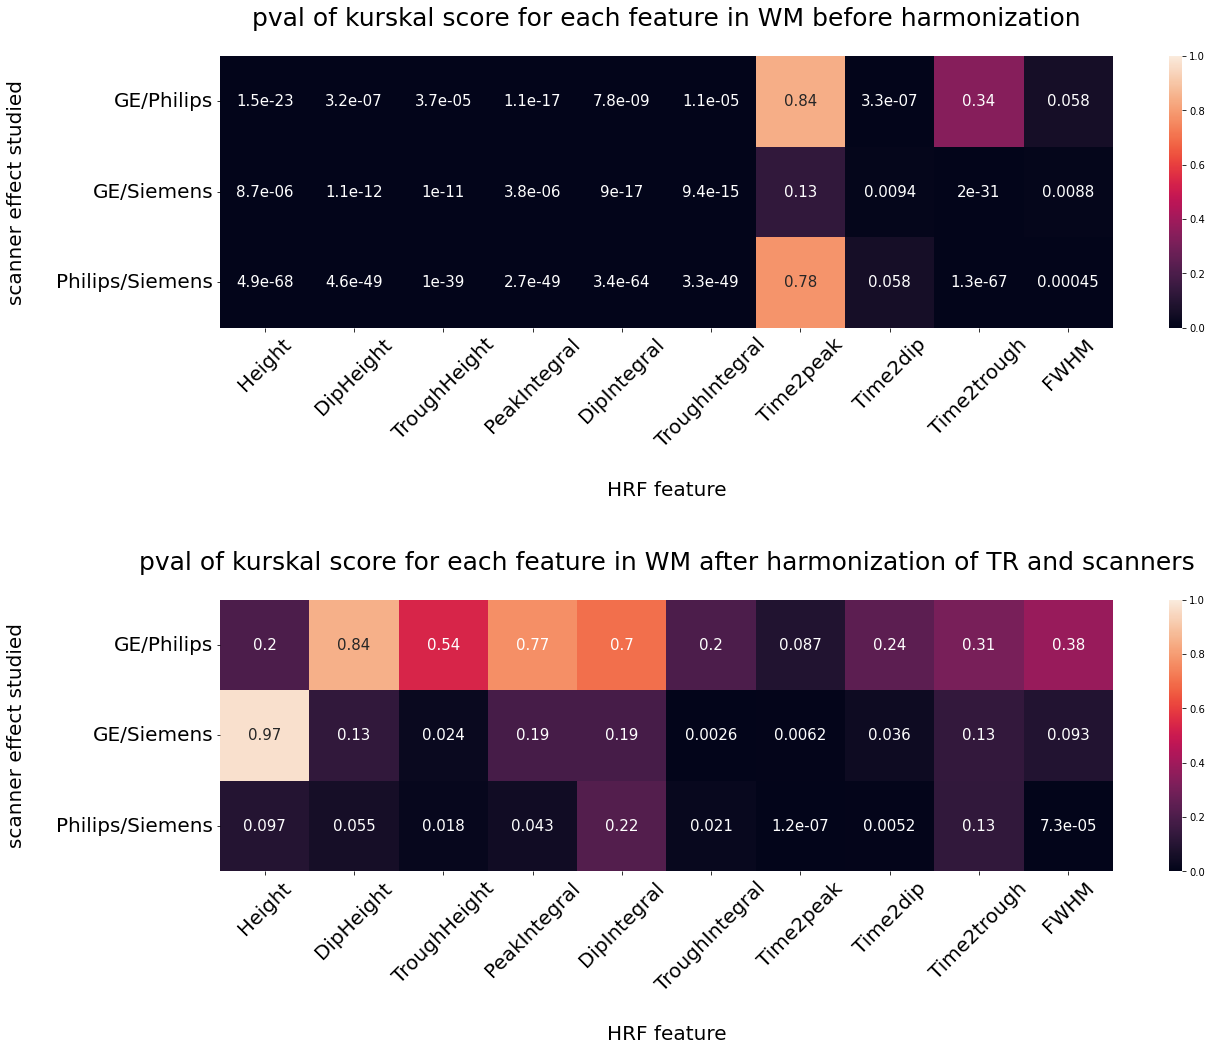

In [137]:
y_axis_name = []
type = 'cohen' ## or ANOVA or cohen
min_x, max_x = 0, 0
mat_d_p = np.zeros(shape=(nb_manu,nb_features))
mat_d = np.zeros(shape=(nb_manu,nb_features))

fig1, ax1 = plt.subplots(nrows=2, ncols=1, figsize=(20,15))
fig2, ax2 = plt.subplots(nrows=2, ncols=1, figsize=(20,15))

for k in range(2):
  tissu = tissus[k]
  for i in range(nb_features):
    feature = params[i]
    file = filedir + feature + '.csv'
    df = pd.read_csv(file)
    
    for j in range(nb_manu):
      scan_1 = combination[j][0]
      scan_2 = combination[j][1]

      df_1 = df.loc[df['Manufacturer']== scan_1]
      df_2 = df.loc[df['Manufacturer']== scan_2]

      name_d = scan_1 + "/" + scan_2
      y_axis_name.append(name_d)

      F, p = stats.kruskal( df_1[tissu],  df_2[tissu])
      cmap = sns.color_palette("rocket", as_cmap=True)

      mat_d[j,i] = F
      mat_d_p[j,i] = p

  min_x = min(mat_d.min(), min_x)
  max_x = max(mat_d.max(), max_x)
  y_axis_name = y_axis_name[0:nb_manu]
  df_d = pd.DataFrame(data=mat_d)
 
  ax = sns.heatmap(mat_d, cmap = cmap, vmax=max_x, vmin=min_x, annot=True,annot_kws={"fontsize":15}, ax=ax1[k] )
  fig1 = set_axis(fig1, ax1[k], params, y_axis_name, 'kurskal', name[k])

  ax = sns.heatmap(mat_d_p, cmap = cmap, vmax=1, vmin=0, annot=True,annot_kws={"fontsize":15}, ax=ax2[k])
  fig2 = set_axis(fig2, ax2[k], params, y_axis_name, 'pval of kurskal', name[k])
    
  y_axis_name = y_axis_name[0:nb_manu]


In [76]:
import itertools

In [129]:
test_type = 'cohen' ## or ANOVA or cohen
min_x = 0
max_x = 0

nb_manu = 1
nb_features = len(params) 
mat_d = np.zeros(shape=(nb_manu,nb_features))

fig = plt.figure(figsize=(20,9))
for k in range(2):
  tissu = tissus[k]
  for i in range(nb_features):
    feature = params[i]
    file = filedir + feature + '.csv'
    df = pd.read_csv(file)
    print(df['TR'].value_counts())

  #   df_1 = df.loc[df['Sex']=='F']
  #   df_2 = df.loc[df['Sex']=='M']

  #   if test_type == 'kruskal':
  #     F, p = stats.kruskal( df_1[tissu],  df_2[tissu])
  #     cmap = sns.color_palette("rocket", as_cmap=True)

  #   elif test_type=='cohen':
  #     p = cohens_d(df_1[tissu], df_2[tissu])
  #     cmap = sns.diverging_palette(240, 10, n=9)
      
  #     mat_d[0,i] = p

  # min_x = min(mat_d.min(), min_x)
  # max_x = max(mat_d.max(), max_x)

  # t= max(abs(min_x), max_x)

  # plt.subplot(2,1,k+1)

  # ax = sns.heatmap(mat_d, cmap = cmap, vmax=t, vmin=-t, annot=True,annot_kws={"fontsize":15}, cbar_kws={"shrink": 2.5})
  # plt.subplots_adjust(hspace=2.5)

  # plt.xticks(np.arange(nb_features)+0.5, params, rotation=45, fontsize=20)

  # plt.title("{} score for each feature in {:}".format(test_type,name[k]), fontsize=25,pad=30)
  # plt.xlabel("HRF feature",labelpad=30, fontsize=20)
  # plt.ylabel("Sex effect studied",labelpad=30, fontsize=20)

# fg.savefig('../../../rsHRF_project/output/plots/ComBAT_cohen_Age_effect.png')

3.000    1069
0.607     146
3.001      85
3.025      19
Name: TR, dtype: int64
3.000    1069
0.607     146
3.001      85
3.025      19
Name: TR, dtype: int64
3.000    1069
0.607     146
3.001      85
3.025      19
Name: TR, dtype: int64
3.000    1069
0.607     146
3.001      85
3.025      19
Name: TR, dtype: int64
3.000    1069
0.607     146
3.001      85
3.025      19
Name: TR, dtype: int64
3.000    1069
0.607     146
3.001      85
3.025      19
Name: TR, dtype: int64
3.000    1069
0.607     146
3.001      85
3.025      19
Name: TR, dtype: int64
3.000    1069
0.607     146
3.001      85
3.025      19
Name: TR, dtype: int64
3.000    1069
0.607     146
3.001      85
3.025      19
Name: TR, dtype: int64
3.000    1069
0.607     146
3.001      85
3.025      19
Name: TR, dtype: int64
3.000    1069
0.607     146
3.001      85
3.025      19
Name: TR, dtype: int64
3.000    1069
0.607     146
3.001      85
3.025      19
Name: TR, dtype: int64
3.000    1069
0.607     146
3.001      85
3.025     

<Figure size 1440x648 with 0 Axes>

average of effect size -0.2306605336697606
average of effect size -0.025406119026237836


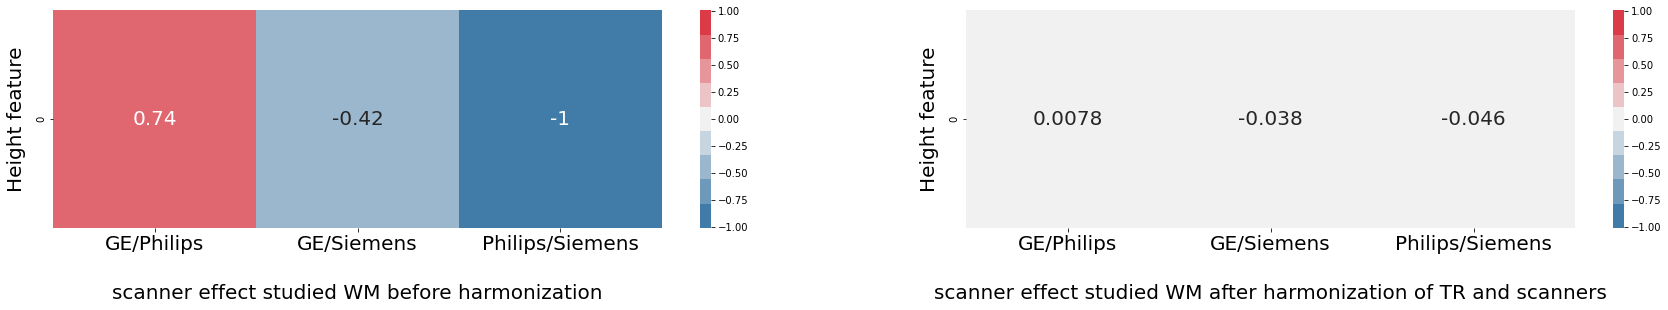

In [56]:
### for the english presenation, to report only one feature

y_axis_name = []
type_test = 'cohen' ## or ANOVA or cohen

mat_d = np.zeros(shape=(1, nb_manu))

tissus = ['WM', 'WM_Harmonization_TR_and_Scanner']

fg =plt.figure(figsize=(2*15,2*2))
feature = params[0]
file = filedir + feature + '.csv'
df = pd.read_csv(file)

for k in range(2):
    tissu = tissus[k]

    for j in range(nb_manu):
        scan_1 = manufacturer[combination[j][0]]
        scan_2 = manufacturer[combination[j][1]]

        df_1 = df.loc[df['Manufacturer']== scan_1]
        df_2 = df.loc[df['Manufacturer']== scan_2]

        name_d = scan_1 + "/" + scan_2
        y_axis_name.append(name_d)

        if type_test == 'Kruskal Willis':
            v, _ = stats.kruskal( df_1[tissu], df_2[tissu])
            cmap = sns.color_palette("rocket", as_cmap=True)

        elif type_test=='cohen':
            v = cohens_d(df_1[tissu], df_2[tissu])
            cmap = sns.diverging_palette(240, 10, n=9)

        elif type_test=='pval':
            _, v = stats.kruskal( df_1[tissu], df_2[tissu])
            cmap = sns.color_palette("rocket", as_cmap=True)

        mat_d[0,j] = v

    if type_test == 'Kruskal Willis':
        min_x = min(mat_d.min(), min_x)
        max_x = max(mat_d.max(), max_x)

    elif type_test=='cohen':
        min_x = min(mat_d.min(), min_x)
        max_x = max(mat_d.max(), max_x)

        t= max(abs(min_x), max_x)
        min_x = -t
        max_x = t

    elif type_test=='pval':
        min_x = 0
        max_x = 1

    print("average of effect size {:}".format(mat_d.mean()))

    plt.subplot(1,2,k+1)
    y_axis_name = y_axis_name[0:nb_manu]
    df_d = pd.DataFrame(data=mat_d)

    ax = sns.heatmap(df_d, cmap = cmap, vmax=max_x, vmin=min_x, annot=True,annot_kws={"fontsize":20})
    plt.subplots_adjust(hspace=1)

    plt.xticks(np.arange(nb_manu)+0.5, y_axis_name, rotation=0, fontsize=20)

    plt.ylabel("Height feature",labelpad=10, fontsize=20)
    plt.xlabel("scanner effect studied {}".format(name[k]),labelpad=30, fontsize=20)

# fg.savefig('presentation_plot_cohen.png')

In [14]:
from sklearn.model_selection import train_test_split

(100, 200)
(100, 200)
(100, 200)
(100, 200)
(100, 200)
(100, 200)
(100, 200)
(100, 200)
(100, 200)
(100, 200)


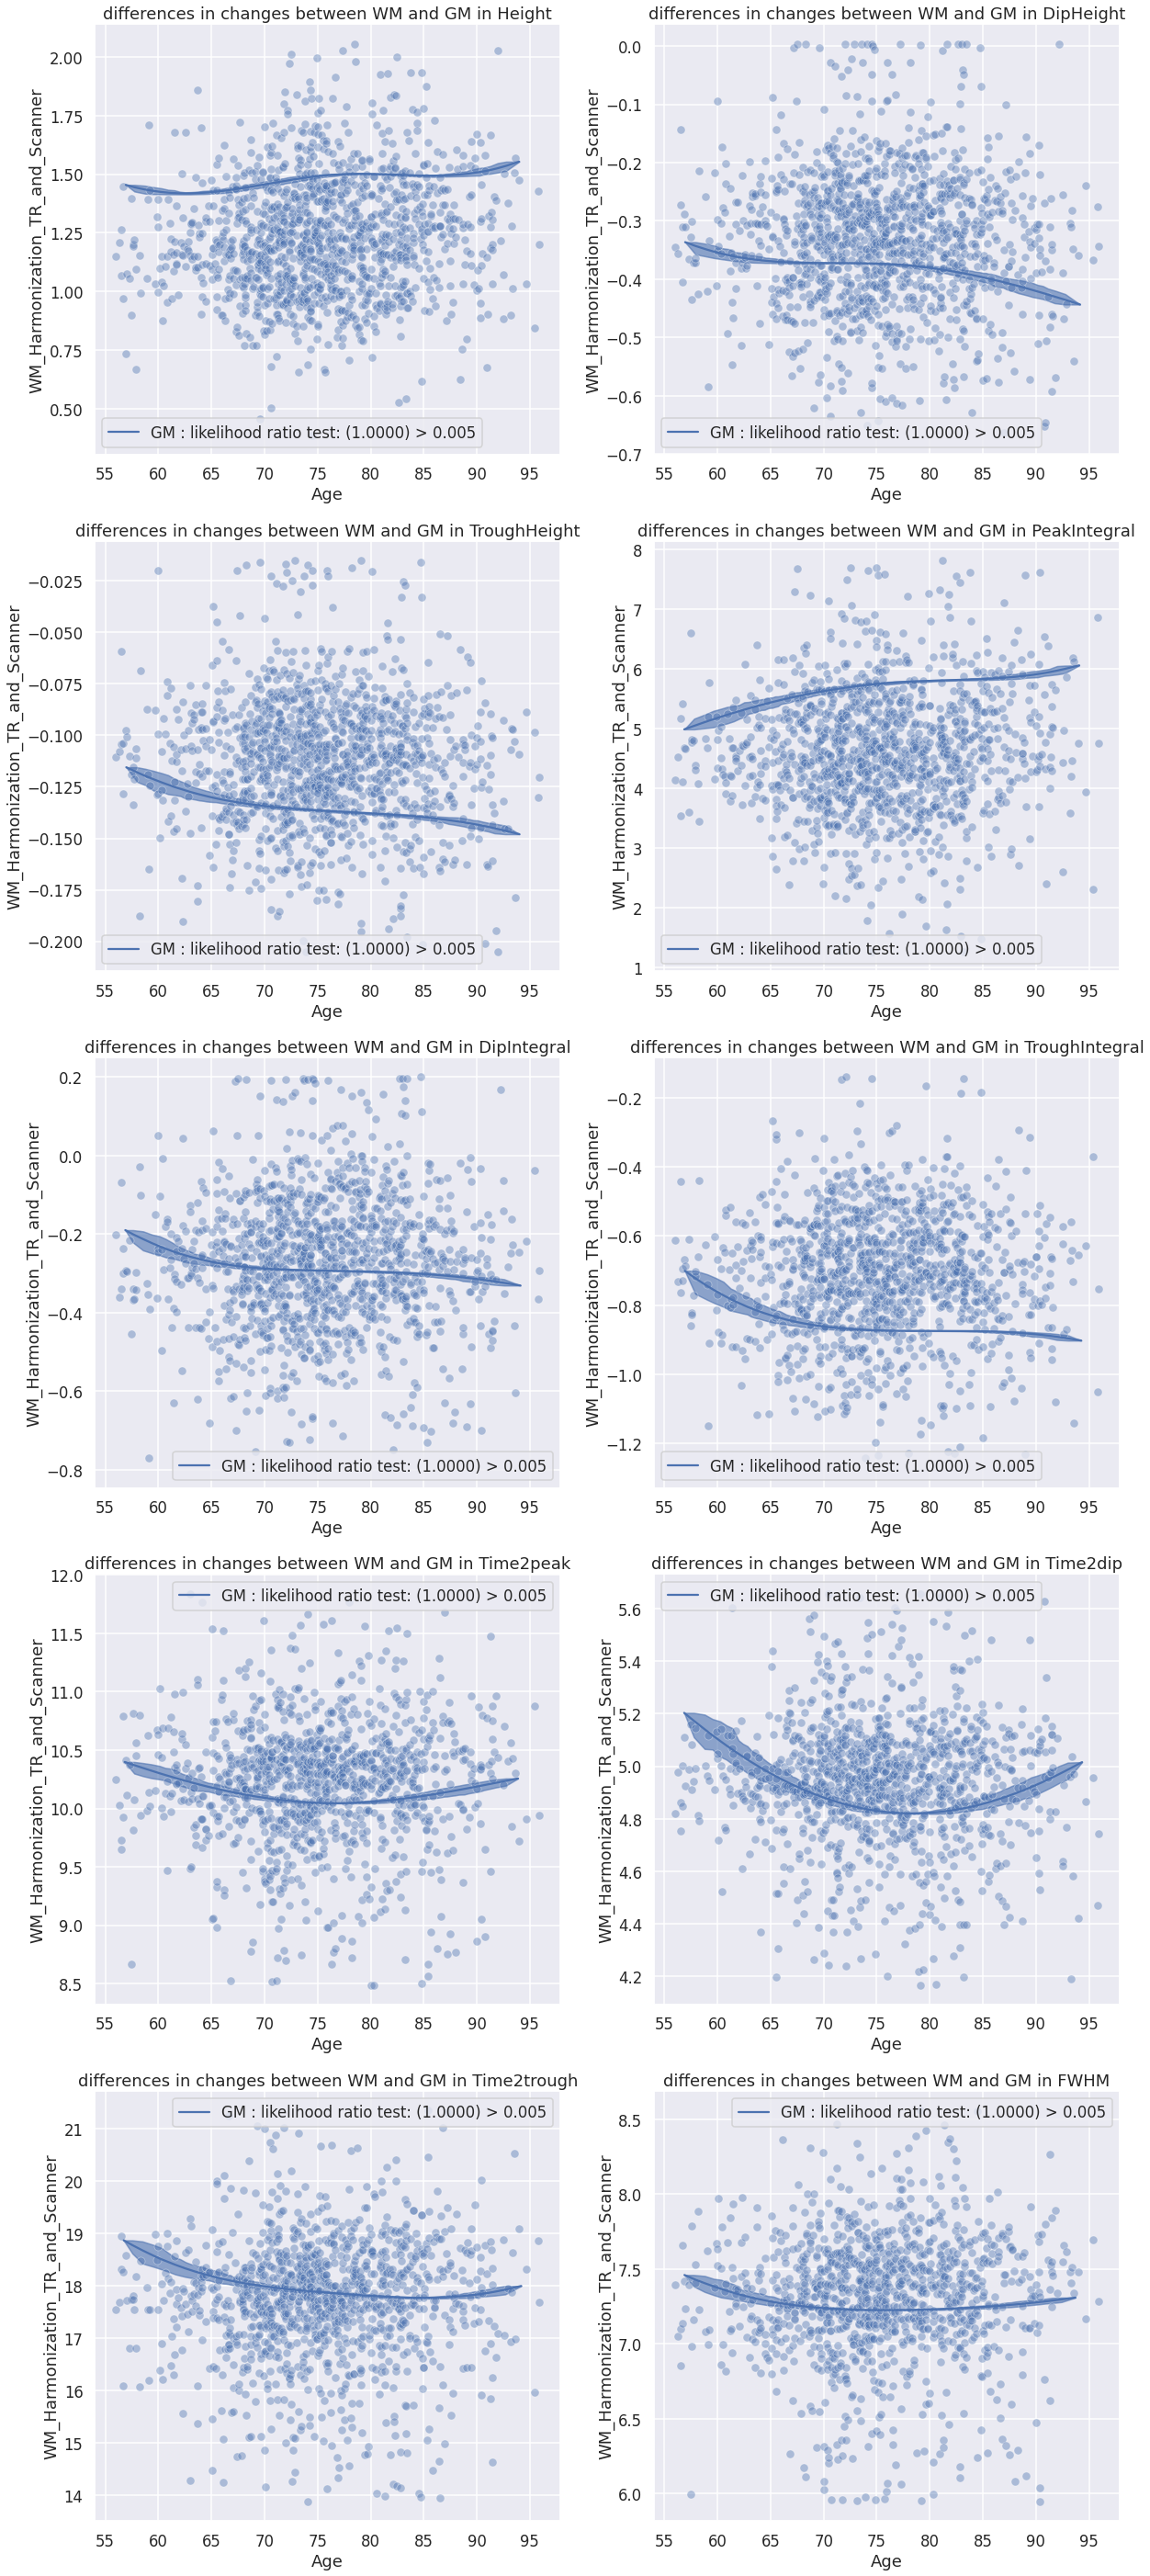

In [136]:
# pal = sns.color_palette() ## 0,1 -- 3,4 -- light-dark
plt.figure(figsize=(20,50))
for i in range(10):
    feature = params[i]
    file = filedir + feature + '.csv'
    df = pd.read_csv(file)
    # df = df.loc[df['TR'] ==0.607]

    df, _ = remove_outlier(df, 'WM_Harmonization_TR_and_Scanner')


    df = df.sort_values('Age')

    plt.subplot(5,2,i+1)
    tit = "differences in changes between WM and GM in {}".format(feature)
    plt.title(tit)
   
    # df = create_indicator(df)
    # print(df)
    
    # m_cub, m_reg  = model_2(df, 'Age', 'Value_Harmonized', [], knots=77, threshold=0.005)
    # x_lim = sorted(df['Age'])
    # x_lim = x_lim[::10]

    # t_lim = df['Tissu']
    # t_lim = t_lim[::10]

    m_cub, m_reg, t  = model_1(df, 'Age', 'GM', [], knots=77, threshold=0.005)
    bs_replicates, out_x  = bootstrap(df,m_cub, 100, 200)
    size_bs= np.shape(bs_replicates)

    print(size_bs)
    # fit = m_cub.predict(dmatrix("indicator*bs(Age, knots =(k,), degree=3)", {"Age": x_lim, "k":77, 'indicator':t_lim}, return_type = 'dataframe'))
    # print(x_lim, fit)
    # sns.lineplot(x=x_lim, y=fit)

    c1 = np.zeros((size_bs[1],))
    c2 = np.zeros((size_bs[1],))
    c_mean = np.zeros((size_bs[1],))
    axis_x  = np.zeros((size_bs[1],))

    for k in range(size_bs[1]):
        c1[k] = np.percentile(bs_replicates[:,k], [5])
        c2[k] = np.percentile(bs_replicates[:,k], [95])
        c_mean[k] = np.mean(bs_replicates[:, k])
        axis_x[k] =np.mean(out_x[:, k])
        
    sns.lineplot(x=axis_x, y=c_mean, label="{} : {}".format('GM', result), color = pal[0])

    plt.fill_between(axis_x, c1,c2, color=pal[0], alpha=0.6)
    sns.scatterplot(x = 'Age', y=col_t, data=df, color=pal[0], alpha=0.4)
    idx_color +=1



    plt.xlabel('Age')
    plt.legend()

10
25
11
5
35
7
29
26
31
17


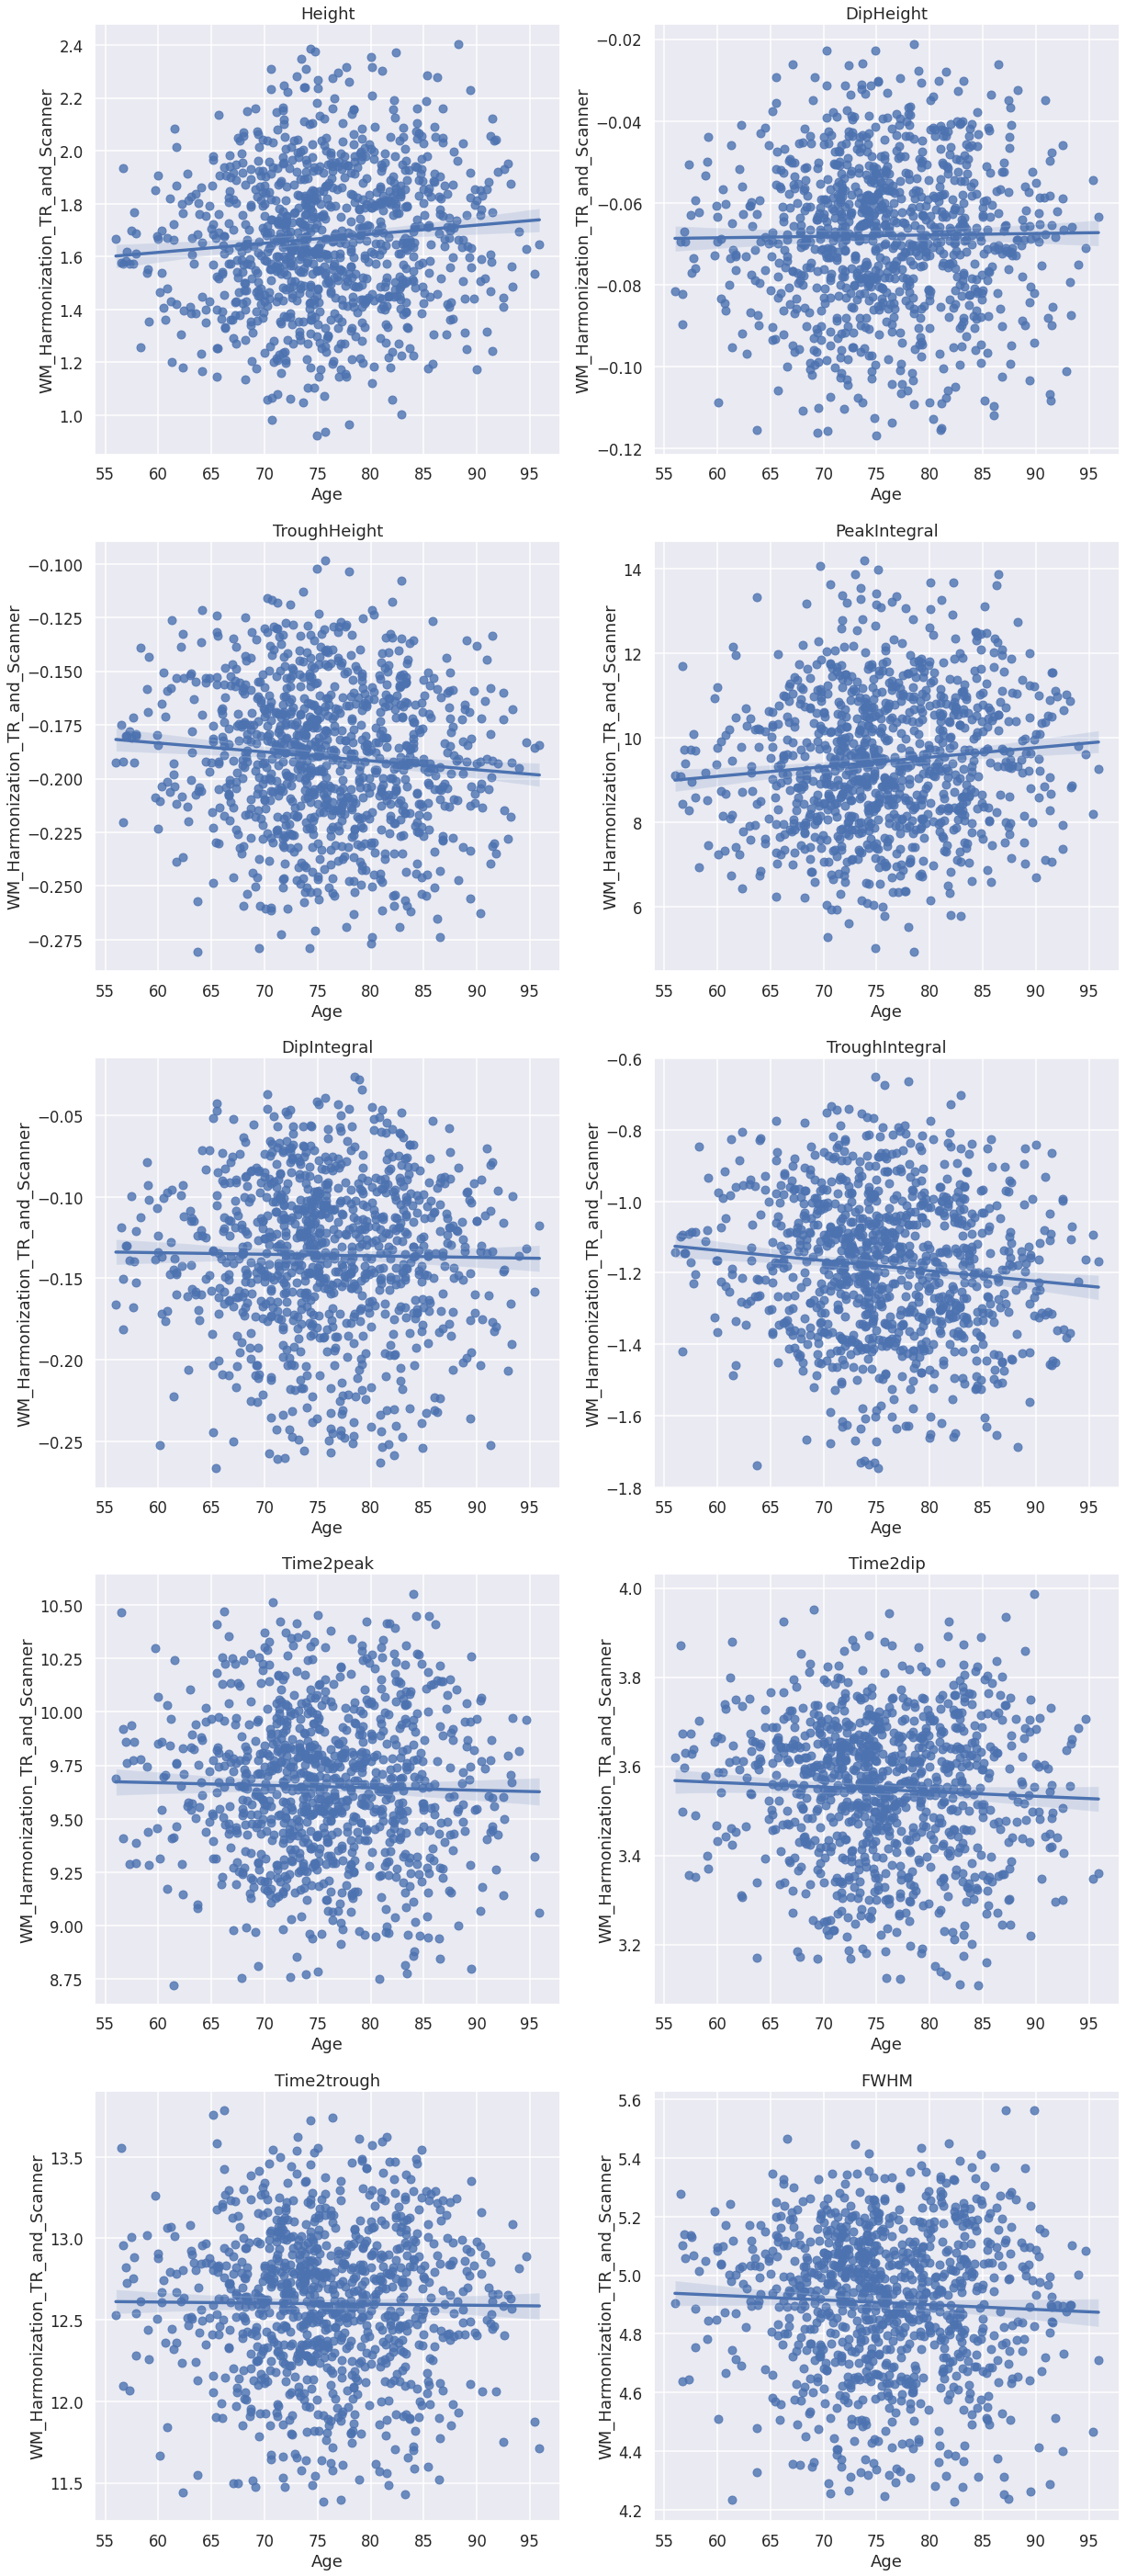

In [74]:
plt.figure(figsize=(20,50))
for i in range(10):
    feature = params[i]
    file = filedir + feature + '_canonical.csv'
    df = pd.read_csv(file)

    df, outlier = remove_outlier(df, 'WM_Harmonization_TR_and_Scanner')
    print(len(outlier))
    # df = pd.merge(df,bad_scans, indicator=True, how='outer').query('_merge=="left_only"').drop('_merge', axis=1)

    plt.subplot(5,2,i+1)
    
    sns.regplot(x = 'Age', y='WM_Harmonization_TR_and_Scanner', data=df, color=pal[0])


    plt.title(feature)
    plt.xlabel('Age')
    # plt.legend()